# Support Vector Machine Model using Different Featurization in NLP

# Loading data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitbohra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"needn't", 'any', 'you', 'hadn', 'myself', 'here', 'were', 'does', 'both', 'not', 'doesn', 'me', 'again', 'haven', 'or', 'them', 'where', 'that', 'can', 'because', 's', "don't", 'has', 'for', 'under', 'about', 'being', "shouldn't", "wouldn't", 'few', 'these', 'once', "didn't", 'aren', 'itself', 'they', 'been', 'above', 'to', 'there', 'between', "she's", 'his', 'ma', "hadn't", 'on', 'some', 'she', 'such', 'but', 'by', 'against', 'most', "isn't", 'having', 'do', 'down', 'whom', 'while', 'wouldn', 'isn', "weren't", 'needn', 'own', 'nor', 'why', 'd', "you'd", 'just', 'which', "shan't", 'in', 'into', 'yourselves', 'ain', "wasn't", 'their', 'its', 'further', 'this', 'won', 'more', 'over', 'before', 'weren', 'those', "it's", 'did', 'themselves', 'will', 'a', 'am', 'with', 'shouldn', 'doing', 'couldn', 'we', 'didn', 'is', "haven't", 'until', "you're", 'should', 're', 'hers', 'an', 'then', 'ours', 'too', 'll', "should've", 'each', 'her', 'when', 'him', "you've", 'my', 'our', "doesn't", 'and', 

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [13]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
final.to_pickle("./amazon.pkl")

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

# [2] Sorting data based on time

In [47]:
# Random sampling
data = final.take(np.random.permutation(len(final))[:100000])

In [48]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
data = data.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(100000, 12)
1    84289
0    15711
Name: Score, dtype: int64


# [3] Spliting into train and test based on time (70:30)

In [49]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

# [4] Bag of Words (BoW)

In [50]:
#Bag of words
count_vect = CountVectorizer(max_features=2000, min_df=20) 

X_train = count_vect.fit_transform(X_train)
print("Train Data Size: ",X_train.shape)

X_test = count_vect.transform(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


## [4.1] Linear SVM

### [4.1.1] LinearSVM with Grid Search

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.0s finished


Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.001}
Best Accuracy: 94.56%


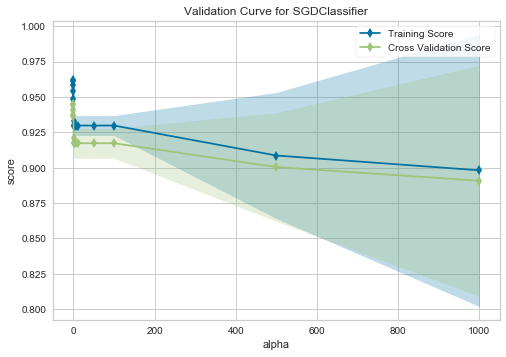

In [52]:
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
gsv = GridSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
gsv.fit(X_train, y_train)
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter(1/C): ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

optimal_alpha = gsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

In [53]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

The optimal value of alpha(1/C) is :  0.001
Accuracy on test set: 90.043%
Precision on test set: 0.907
Recall on test set: 0.979
F1-Score on test set: 0.942


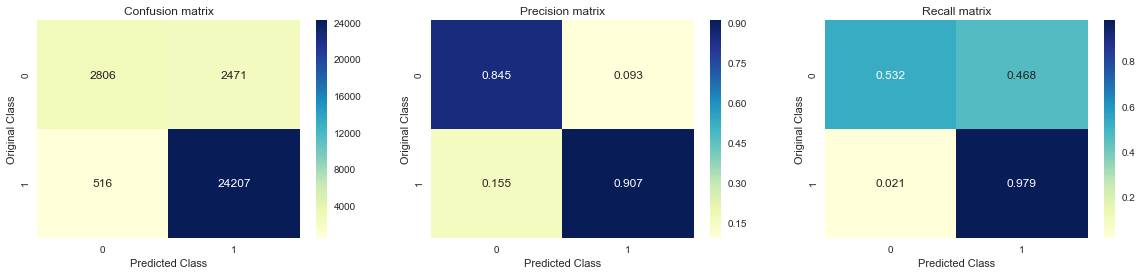

In [54]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### [4.1.2] LinearSVM with Random Search

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished


Model with best parameters :
 SGDClassifier(alpha=0.0005, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.0005}
Best Accuracy: 94.51%


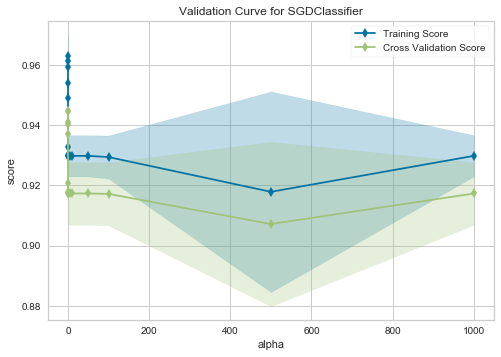

In [55]:
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
rsv = RandomizedSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
rsv.fit(X_train, y_train)
print("Model with best parameters :\n",rsv.best_estimator_)
print("Best HyperParameter(1/C): ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))

optimal_alpha = rsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(rsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.0005
Accuracy on test set: 90.403%
Precision on test set: 0.922
Recall on test set: 0.965
F1-Score on test set: 0.943


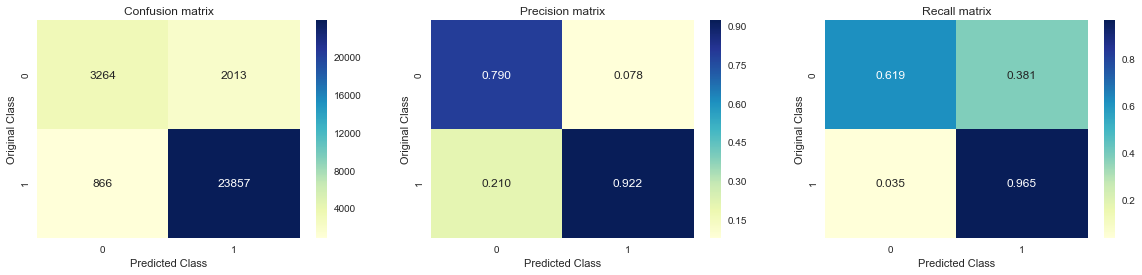

In [56]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### [4.1.3] Feature Importance

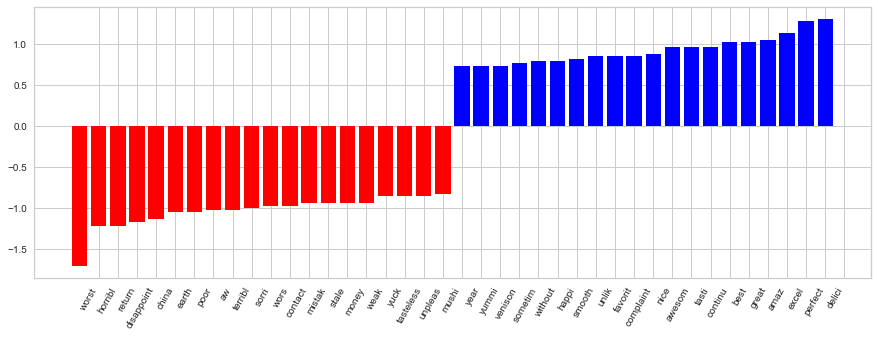

In [97]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()
cv = CountVectorizer()
cv.fit(X_train)
len(cv.vocabulary_)
cv.get_feature_names()
X_train = cv.transform(X_train)

#LinearSVM 
sgd = SGDClassifier(alpha=0.0005, n_jobs=-1)
sgd.fit(X_train, y_train)
plot_coefficients(sgd, cv.get_feature_names())

## [4.2] SVM with RBF Kernel

In [14]:
# Random sampling
df = final.take(np.random.permutation(len(final))[:20000])
df['Time'] = pd.to_datetime(df['Time'])
# Sort by time
df = df.sort_values(by='Time')
print(df.shape)
print(df['Score'].value_counts())

# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

(20000, 12)
1    16774
0     3226
Name: Score, dtype: int64


In [15]:
#Bag of words
count_vect = CountVectorizer(max_features=2000, min_df=20) 

X_train = count_vect.fit_transform(X_train)
print("Train Data Size: ",X_train.shape)

X_test = count_vect.transform(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 2000)
Test Data Size:  (6000, 2000)


In [16]:
# Converting sparse matrix to dense matrix
from sklearn.decomposition import TruncatedSVD 
tsvd = TruncatedSVD(n_components=100) 

X_train = tsvd.fit(X_train).transform(X_train)
print(X_train.shape)

X_test = tsvd.fit(X_test).transform(X_test)
print(X_test.shape)

(14000, 100)
(6000, 100)


In [17]:
from sklearn import svm

Cs = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
gammas = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'C': Cs, 'gamma' : gammas}
tscv = TimeSeriesSplit(n_splits=5)
gsv = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=tscv,scoring='f1_micro',verbose=1,n_jobs=-1)
gsv.fit(X_train, y_train)
gsv.best_params_
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter(1/C): ",gsv.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 76.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 123.4min
/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 141.4min finished


Model with best parameters :
 SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Accuracy: 85.68%
Best HyperParameter(1/C):  {'C': 5, 'gamma': 0.05}


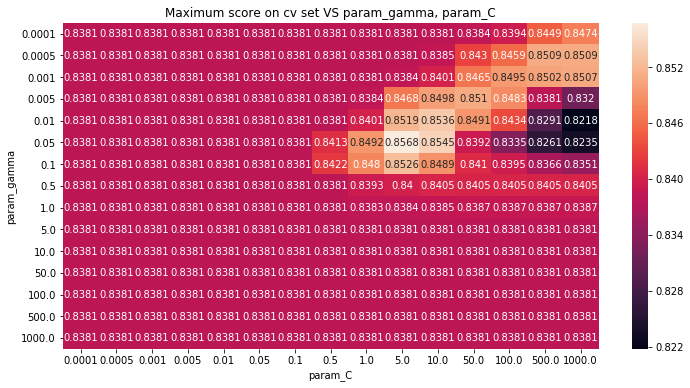

In [18]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_gamma','param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on cv set VS param_gamma, param_C'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

Accuracy on test set: 75.800%
Precision on test set: 0.826
Recall on test set: 0.893
F1-Score on test set: 0.858


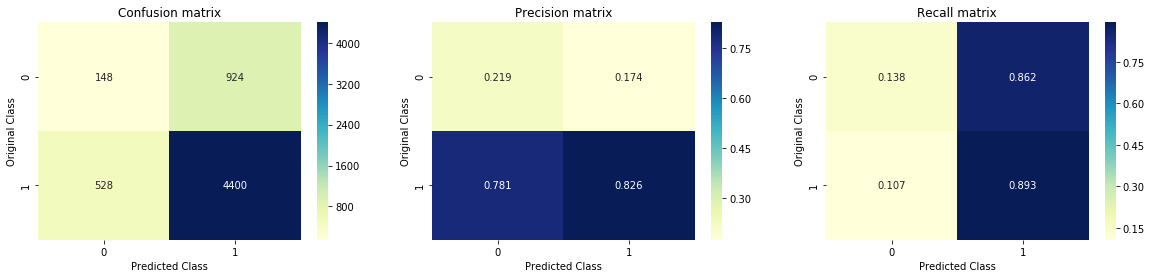

In [21]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=5,gamma=0.05)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [5] TF-IDF

In [57]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [58]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=20) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
print("Train Data Size: ",X_train.shape)

X_test = tfidf.transform(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


## [5.1] Linear SVM

### [5.1.1] Linear SVM with Grid Search

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.2s finished


Model with best parameters :
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.0001}
Best Accuracy: 94.55%


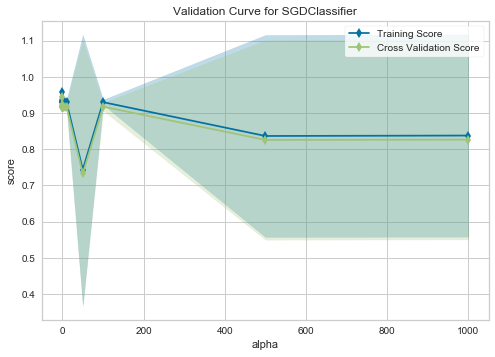

In [67]:
warnings.filterwarnings("ignore")
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
gsv = GridSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
gsv.fit(X_train, y_train)
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter(1/C): ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

optimal_alpha = gsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.0001
Accuracy on test set: 89.997%
Precision on test set: 0.901
Recall on test set: 0.987
F1-Score on test set: 0.942


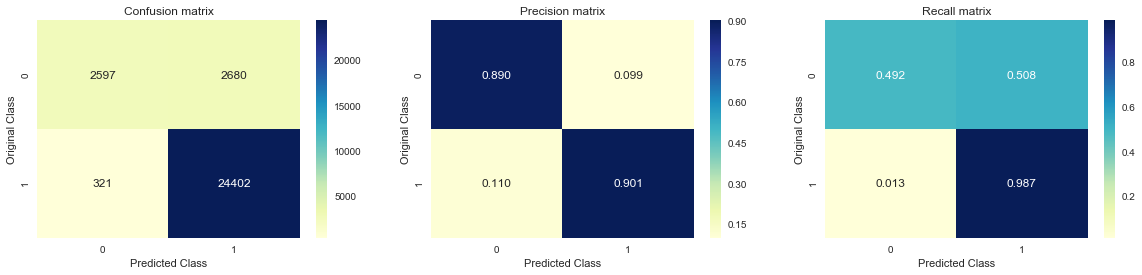

In [68]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### [5.1.2] Linear SVM with Random Search

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


Model with best parameters :
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.0001}
Best Accuracy: 94.58%


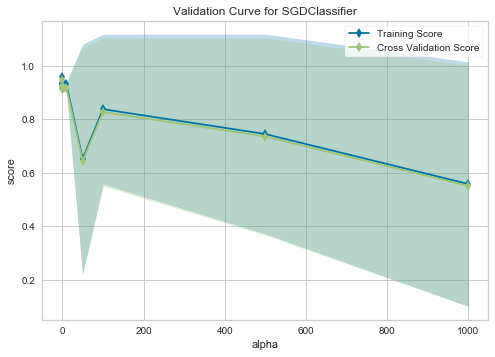

In [69]:
warnings.filterwarnings("ignore")
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
rsv = RandomizedSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
rsv.fit(X_train, y_train)
print("Model with best parameters :\n",rsv.best_estimator_)
print("Best HyperParameter(1/C): ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))

optimal_alpha = rsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(rsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.0001
Accuracy on test set: 90.027%
Precision on test set: 0.901
Recall on test set: 0.987
F1-Score on test set: 0.942


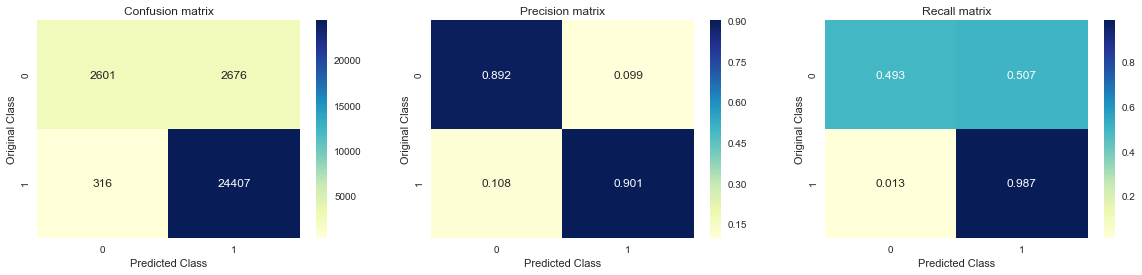

In [70]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### [5.1.3] Feature Importance

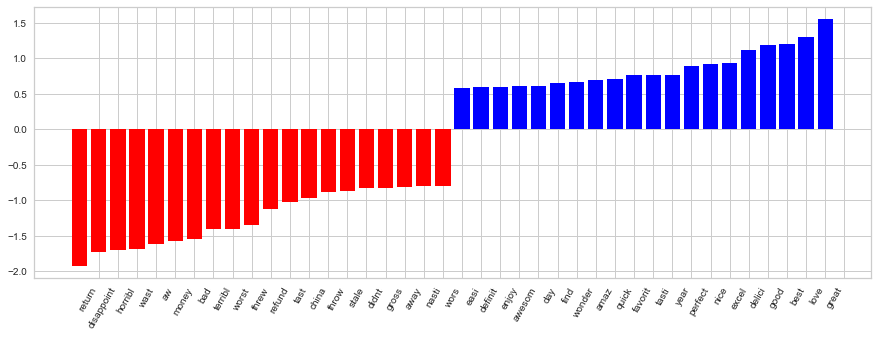

In [100]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
len(tfidf.vocabulary_)
tfidf.get_feature_names()
X_train = tfidf.transform(X_train)

#LinearSVM 
sgd = SGDClassifier(alpha=0.0005, n_jobs=-1)
sgd.fit(X_train, y_train)
plot_coefficients(sgd, cv.get_feature_names())

## [5.2] SVM with RBF Kernel

In [25]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

In [26]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=20) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
print("Train Data Size: ",X_train.shape)

X_test = tfidf.transform(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 2000)
Test Data Size:  (6000, 2000)


In [27]:
# Converting sparse matrix to dense matrix
from sklearn.decomposition import TruncatedSVD 
tsvd = TruncatedSVD(n_components=100) 

X_train = tsvd.fit(X_train).transform(X_train)
print(X_train.shape)

X_test = tsvd.fit(X_test).transform(X_test)
print(X_test.shape)

(14000, 100)
(6000, 100)


In [28]:
from sklearn import svm

Cs = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
gammas = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'C': Cs, 'gamma' : gammas}
tscv = TimeSeriesSplit(n_splits=5)
gsv = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=tscv,scoring='f1_micro',verbose=1,n_jobs=-1)
gsv.fit(X_train, y_train)
gsv.best_params_
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter(1/C): ",gsv.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 100.0min finished


Model with best parameters :
 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Accuracy: 88.34%
Best HyperParameter(1/C):  {'C': 1000, 'gamma': 0.05}


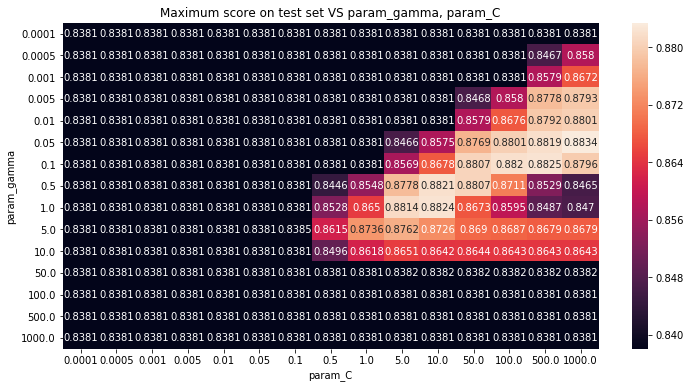

In [29]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_gamma','param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_gamma, param_C'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

Accuracy on test set: 76.250%
Precision on test set: 0.829
Recall on test set: 0.896
F1-Score on test set: 0.861


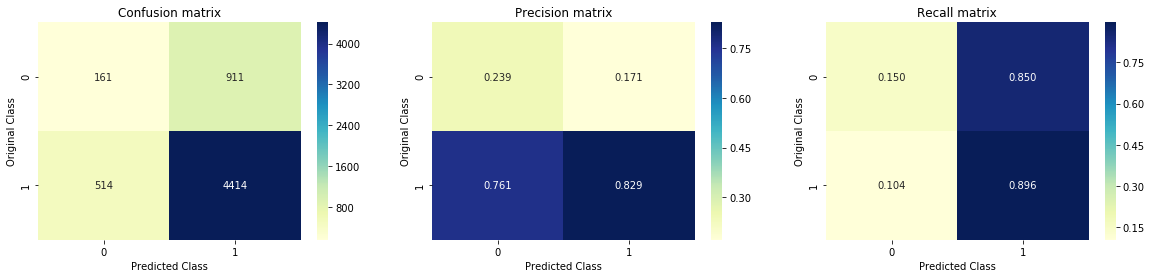

In [30]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=1000,gamma=0.05)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [6] Word2Vec

In [71]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [72]:
print(data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [73]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [74]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12716
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment', 'beetlejuic', 'excel']


# [7] Avg Word2Vec

In [75]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 100000/100000 [03:43<00:00, 448.38it/s]

100000
50


In [77]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [7.1] Linear SVM

### [7.1.1] Linear SVM with Grid Search

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.2min finished


Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.001}
Best Accuracy: 93.67%


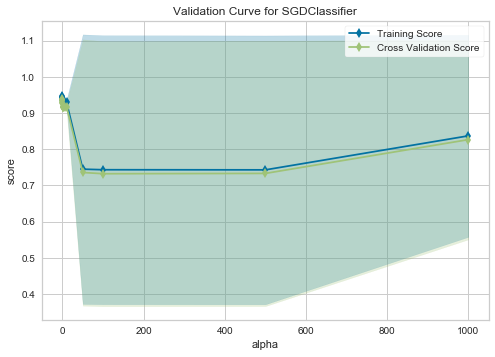

In [78]:
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
gsv = GridSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
gsv.fit(X_train, y_train)
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter(1/C): ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

optimal_alpha = gsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.001
Accuracy on test set: 88.340%
Precision on test set: 0.895
Recall on test set: 0.972
F1-Score on test set: 0.932


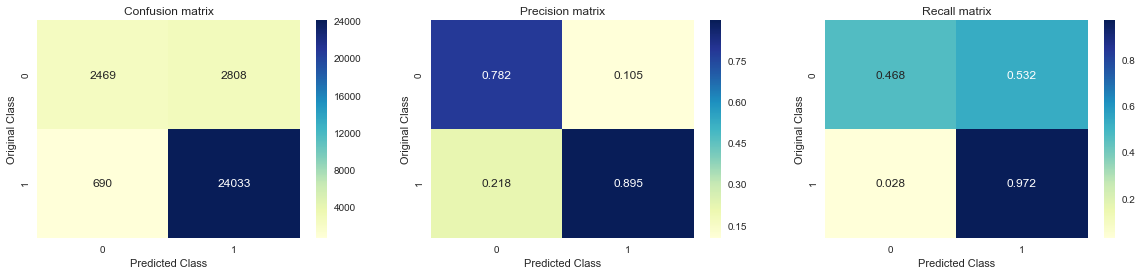

In [79]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### [7.1.2] Linear SVM with Random Search

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.01}
Best Accuracy: 92.99%


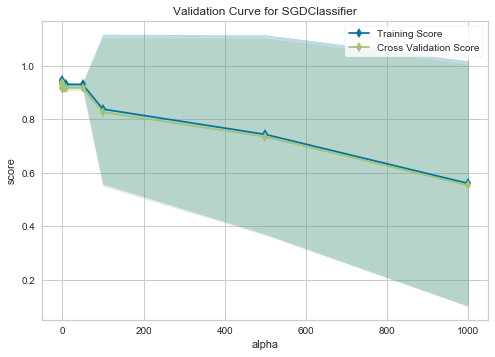

In [80]:
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
rsv = RandomizedSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
rsv.fit(X_train, y_train)
print("Model with best parameters :\n",rsv.best_estimator_)
print("Best HyperParameter(1/C): ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))

optimal_alpha = rsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(rsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.01
Accuracy on test set: 87.033%
Precision on test set: 0.871
Recall on test set: 0.989
F1-Score on test set: 0.926


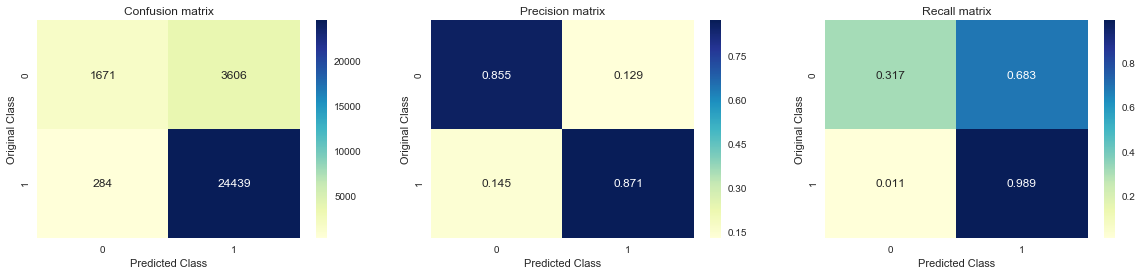

In [81]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [7.2] SVM with RBF Kernel

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:31<00:00, 636.77it/s]

20000
50


In [43]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, df['Score'].values, test_size=0.3, shuffle=False)

In [44]:
from sklearn import svm

Cs = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
gammas = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'C': Cs, 'gamma' : gammas}
tscv = TimeSeriesSplit(n_splits=5)
gsv = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=tscv,scoring='f1_micro',verbose=1,n_jobs=-1)
gsv.fit(X_train, y_train)
gsv.best_params_
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter(1/C): ",gsv.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 78.0min finished


Model with best parameters :
 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Accuracy: 87.45%
Best HyperParameter(1/C):  {'C': 10, 'gamma': 0.1}


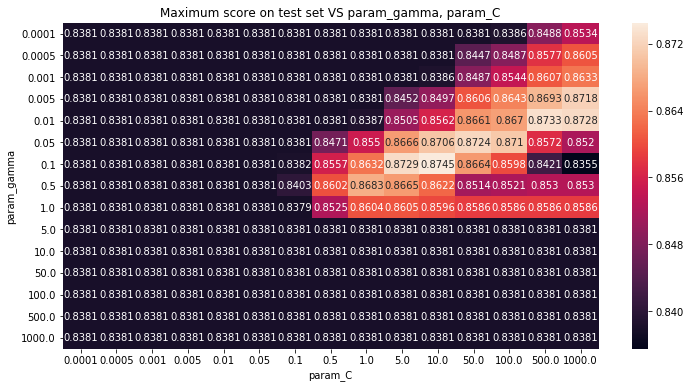

In [45]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_gamma','param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_gamma, param_C'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

Accuracy on test set: 87.667%
Precision on test set: 0.890
Recall on test set: 0.969
F1-Score on test set: 0.928


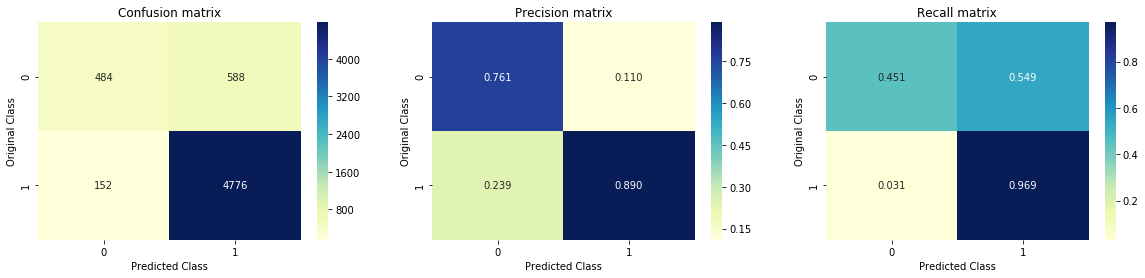

In [46]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=10,gamma=0.1)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [8] TF-IDF Word2Vec

In [82]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [83]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 100000/100000 [04:20<00:00, 383.71it/s]


In [84]:
#Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [8.1] Linear SVM

### [8.1.1] Linear SVM with Grid Search

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.5min finished


Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.001}
Best Accuracy: 92.91%


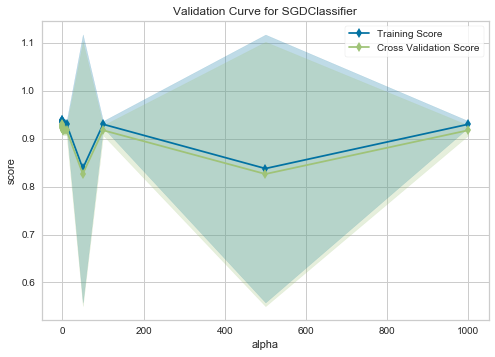

In [85]:
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
gsv = GridSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
gsv.fit(X_train, y_train)
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter(1/C): ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

optimal_alpha = gsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.001
Accuracy on test set: 86.083%
Precision on test set: 0.867
Recall on test set: 0.981
F1-Score on test set: 0.921


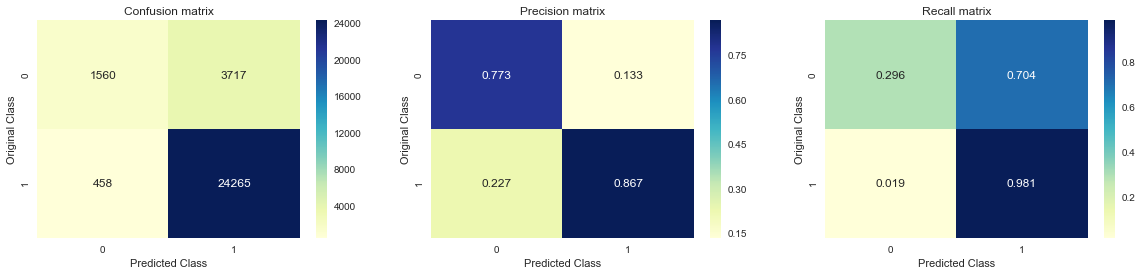

In [86]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### [8.1.2] Linear SVM with Random Search

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


Model with best parameters :
 SGDClassifier(alpha=0.0005, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter(1/C):  {'alpha': 0.0005}
Best Accuracy: 92.89%


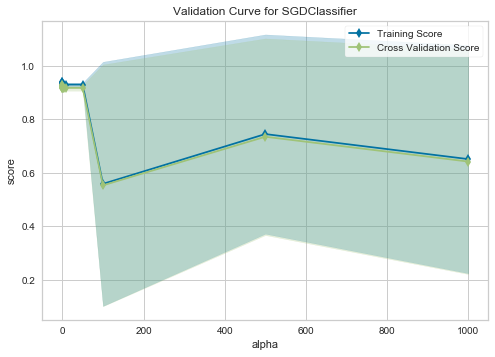

In [87]:
from sklearn.linear_model import SGDClassifier
from yellowbrick.model_selection import ValidationCurve

svm = SGDClassifier()
param_range = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'alpha':param_range}
tscv = TimeSeriesSplit(n_splits=10)
rsv = RandomizedSearchCV(svm, param_grid, scoring='f1', cv=tscv, n_jobs=-1, verbose=1)
rsv.fit(X_train, y_train)
print("Model with best parameters :\n",rsv.best_estimator_)
print("Best HyperParameter(1/C): ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))

optimal_alpha = rsv.best_estimator_.alpha

#Validation Curve
viz = ValidationCurve(rsv.best_estimator_, param_name="alpha",param_range=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], cv=tscv, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

The optimal value of alpha(1/C) is :  0.0005
Accuracy on test set: 86.373%
Precision on test set: 0.871
Recall on test set: 0.979
F1-Score on test set: 0.922


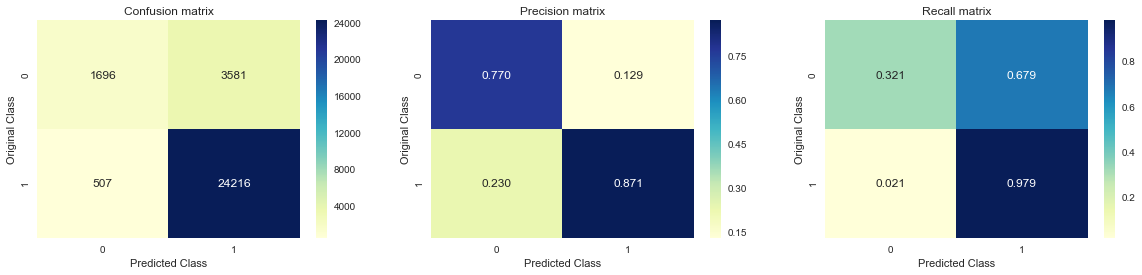

In [88]:
#Testing Accuracy on Test data
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [8.2] SVM with RBF Kernel

In [40]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:39<00:00, 501.55it/s]


In [42]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, df['Score'].values, test_size=0.3, shuffle=False)

In [113]:
from sklearn import svm

Cs = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
gammas = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'C': Cs, 'gamma' : gammas}
tscv = TimeSeriesSplit(n_splits=5)
gsv = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=tscv,scoring='f1_micro',verbose=1,n_jobs=-1)
gsv.fit(X_train, y_train)
gsv.best_params_
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter(1/C): ",gsv.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    7.3s


Model with best parameters :
 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Accuracy: 83.97%
Best HyperParameter(1/C):  {'C': 1000, 'gamma': 0.05}


[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:   17.7s finished


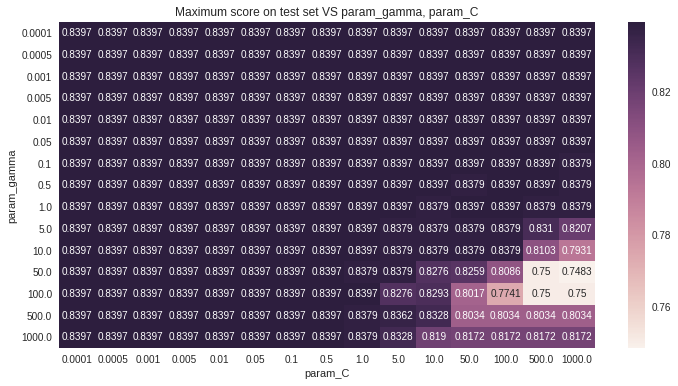

In [114]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_gamma','param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_gamma, param_C'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

Accuracy on test set: 82.667%
Precision on test set: 0.827
Recall on test set: 1.000
F1-Score on test set: 0.905


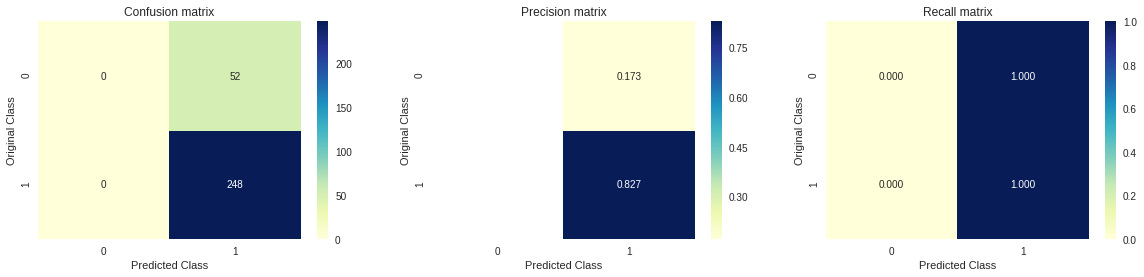

In [115]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=100,gamma=0.005)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

In [90]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "KERNEL", "MODEL", "ALPHA(1/C)", "F1-SCORE"]
 
x.add_row(["BOW", "Linear", "Grid Search", 0.001, 0.942]) 
x.add_row(["","", "Random Search", 0.0005, 0.943]) 
 
x.add_row(["TF_IDF", "Linear", "Grid Search", 0.0001, 0.942]) 
x.add_row(["", "", "Random Search", 0.0001, 0.942])
 
x.add_row(["AVG_W2VEC", "Linear", "Grid Search", 0.001, 0.932]) 
x.add_row(["", "", "Random Search", 0.01,  0.926])

x.add_row(["TFIDF_W2VEC", "Linear", "Grid Search", 0.001, 0.921]) 
x.add_row(["", "", "Random Search", 0.0005, 0.922])
 
print('\t\t\tSVM WITH LINEAR_KERNEL')
print(x)

			SVM WITH LINEAR_KERNEL
+---------------+--------+---------------+------------+----------+
| FEATURIZATION | KERNEL |     MODEL     | ALPHA(1/C) | F1-SCORE |
+---------------+--------+---------------+------------+----------+
|      BOW      | Linear |  Grid Search  |   0.001    |  0.942   |
|               |        | Random Search |   0.0005   |  0.943   |
|     TF_IDF    | Linear |  Grid Search  |   0.0001   |  0.942   |
|               |        | Random Search |   0.0001   |  0.942   |
|   AVG_W2VEC   | Linear |  Grid Search  |   0.001    |  0.932   |
|               |        | Random Search |    0.01    |  0.926   |
|  TFIDF_W2VEC  | Linear |  Grid Search  |   0.001    |  0.921   |
|               |        | Random Search |   0.0005   |  0.922   |
+---------------+--------+---------------+------------+----------+


In [89]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "KERNEL", "MODEL", "C","GAMMA", "F1-SCORE"]
x.add_row(["BOW", "RBF", "Grid Search", 5, 0.05, 0.858])
x.add_row(["TF_IDF", "RBF", "Grid Search", 1000, 0.05, 0.861])
x.add_row(["AVG_W2VE", "RBF", "Grid Search", 10, 0.1, 0.928])
x.add_row(["TFIDF_W2VEC", "RBF", "Grid Search", 100, 0.005, 0.905])

print('\t\t\tSVM WITH RBF_KERNEL')
print(x)

			SVM WITH RBF_KERNEL
+---------------+--------+-------------+------+-------+----------+
| FEATURIZATION | KERNEL |    MODEL    |  C   | GAMMA | F1-SCORE |
+---------------+--------+-------------+------+-------+----------+
|      BOW      |  RBF   | Grid Search |  5   |  0.05 |  0.858   |
|     TF_IDF    |  RBF   | Grid Search | 1000 |  0.05 |  0.861   |
|    AVG_W2VE   |  RBF   | Grid Search |  10  |  0.1  |  0.928   |
|  TFIDF_W2VEC  |  RBF   | Grid Search | 100  | 0.005 |  0.905   |
+---------------+--------+-------------+------+-------+----------+


# Conclusion

  1. BOW Featurization with linear kernel with random search gave the best results with F1-score of 0.943.
  2. Avg-w2v Featurization with RBF Kernel (C=10, gamma=0.1) gave the best results with F1-score of 0.928
  3. SVM with RBF kernel the separating plane exists in another space.
  4. Using SGDClasiifier takes very less time to train.